## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [1]:
# Importing the necessary libraries

import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime

import warnings
warnings.filterwarnings("ignore")

import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [5]:
# Configure the dataset path here
project_folder='datasets/Project_data'


# Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
class GenerateModel(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def setup_model(self):
        pass
    

### Defining Plot Function

In [7]:
# function to plot the training & validation accuracies/losses.

def lossAccuracyPlot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## 1. CNN 3D - 3D Convolution Models
### Model 1 - Sample model used for initial experiments

The sample model provides a starting point for the experiments to understand various hyperparameters. Based on the results of the models, we can optimize the hyperparameters and get the better accuracies and reduce the loss.

In [21]:
class Conv3DModel_0(GenerateModel):
    
    def setup_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
    

In [22]:
conv_3d1=Conv3DModel_0()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.setup_model()
conv_3d1_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_25 (Activation)  (None, 15, 80, 80, 32)   

##### Sample Cropping of image

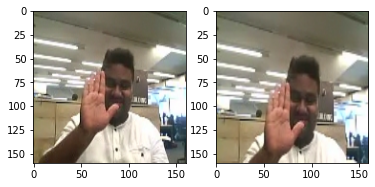

In [12]:
test_generator=Conv3DModel_0()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size
##### Below are the experiments to see how training time is affected by 
1. image resolution, 
2. number of images in sequence and 
3. batch size

### Experiment 1: 
1. image size = 100 X 100, 
2. batch size = 30, 
3. frames to sample = 16

In [13]:
conv_3d1=Conv3DModel_0()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.setup_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2


2022-05-15 17:25:12.766979: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.5067 - categorical_accuracy: 0.4525
Epoch 00001: val_loss improved from inf to 2.46641, saving model to model_init_2022-05-1517_25_07.607006/model-00001-1.50674-0.45249-2.46641-0.21000.h5
23/23 [==============================] - 87s 4s/step - loss: 1.5067 - categorical_accuracy: 0.4525 - val_loss: 2.4664 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 0.8781 - categorical_accuracy: 0.6576
Epoch 00002: val_loss did not improve from 2.46641
23/23 [==============================] - 86s 4s/step - loss: 0.8781 - categorical_accuracy: 0.6576 - val_loss: 4.3228 - val_categorical_accuracy: 0.2200 - lr: 0.0010


### Experiment 2: 
1. image size = 100 X 100, 
2. batch size = 20, 
3. frames to sample = 30

In [14]:
conv_3d1=Conv3DModel_0()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.setup_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.5428 - categorical_accuracy: 0.4268
Epoch 00001: val_loss improved from inf to 3.00423, saving model to model_init_2022-05-1517_28_06.643972/model-00001-1.54285-0.42685-3.00423-0.13000.h5
34/34 [==============================] - 158s 5s/step - loss: 1.5428 - categorical_accuracy: 0.4268 - val_loss: 3.0042 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 1.0273 - categorical_accuracy: 0.6078
Epoch 00002: val_loss did not improve from 3.00423
34/34 [==============================] - 159s 5s/step - loss: 1.0273 - categorical_accuracy: 0.6078 - val_loss: 6.4163 - val_categorical_accuracy: 0.2000 - lr: 0.0010


### Experiment 3: 
1. image size = 160 X 160, 
2. batch size = 15, 
3. frames to sample = 30

In [15]:
conv_3d1=Conv3DModel_0()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.setup_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5452 - categorical_accuracy: 0.4238
Epoch 00001: val_loss improved from inf to 6.99744, saving model to model_init_2022-05-1517_33_38.622722/model-00001-1.54515-0.42383-6.99744-0.21000.h5
45/45 [==============================] - 180s 4s/step - loss: 1.5452 - categorical_accuracy: 0.4238 - val_loss: 6.9974 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.1023 - categorical_accuracy: 0.5867
Epoch 00002: val_loss did not improve from 6.99744
45/45 [==============================] - 178s 4s/step - loss: 1.1023 - categorical_accuracy: 0.5867 - val_loss: 8.2667 - val_categorical_accuracy: 0.2900 - lr: 0.0010


### Experiment 4: 
1. image size = 160 X 160, 
2. batch size = 30, 
3. frames to sample = 16

In [16]:
conv_3d1=Conv3DModel_0()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.setup_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.4038 - categorical_accuracy: 0.5038
Epoch 00001: val_loss improved from inf to 2.00074, saving model to model_init_2022-05-1517_39_45.062291/model-00001-1.40376-0.50377-2.00074-0.21000.h5
23/23 [==============================] - 97s 4s/step - loss: 1.4038 - categorical_accuracy: 0.5038 - val_loss: 2.0007 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 0.8492 - categorical_accuracy: 0.6727
Epoch 00002: val_loss did not improve from 2.00074
23/23 [==============================] - 95s 4s/step - loss: 0.8492 - categorical_accuracy: 0.6727 - val_loss: 2.5504 - val_categorical_accuracy: 0.1700 - lr: 0.0010


- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 15-40 based on model performance
- We will change the resoulution 160 X 160, 120 X 120, 100 X 100 and 80 X 80 according the model performance


## Model 2
### Base Model
#### Image Size = 160 X 160, Batch Size = 40, No. of Epochs = 15, Frames to Sample = 20
To start with the experiments of building models using CNN3D, the initial parameters are set. Once the model is executed, we can start optimizing hyperparameters based on the model performance.

In [8]:
class Conv3DModel_1(GenerateModel):
    
    def setup_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
conv_3d1=Conv3DModel_1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.setup_model()
conv_3d1_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_29 (Conv3D)          (None, 20, 160, 160, 32)  13856     
                                                                 
 activation_29 (Activation)  (None, 20, 160, 160, 32)  0         
                                                                 
 batch_normalization_43 (Bat  (None, 20, 160, 160, 32)  128      
 chNormalization)                                     

In [25]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 65833861
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.4707 - categorical_accuracy: 0.4510
Epoch 00001: val_loss improved from inf to 3.91935, saving model to model_init_2022-05-1517_54_04.595319/model-00001-1.47073-0.45098-3.91935-0.24000.h5
17/17 [==============================] - 123s 8s/step - loss: 1.4707 - categorical_accuracy: 0.4510 - val_loss: 3.9193 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.8619 - categorical_accuracy: 0.6712
Epoch 00002: val_loss improved from 3.91935 to 1.69571, saving model to model_init_2022-05-1517_54_04.595319/model-00002-0.86195-0.67119-1.69571-0.36000.h5
17/17 [==============================] - 121s 7s/step - loss: 0.8619 - categorical_accuracy: 0.6712 - val_loss: 1.6957 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6082 - categorical_accuracy: 0.7783
Epoch 00003: val_

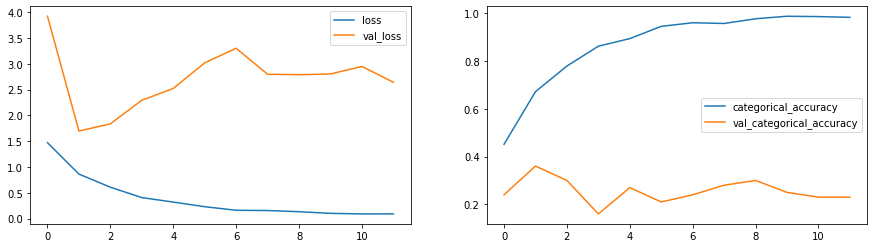

In [26]:
lossAccuracyPlot(history_model1)

##### Model is clearly overfitting. There have not been any improvement in the model since last 10 epoch, so early stopping is executed @epoch 12. The model is not able to converge and hence there is no point in executing this model. We will reduce the batch size and increase the number of epochs to see if there is any improvement in the model. Also, we can add dropout 50% to address overfitting
1. Total No. of parameters = 65,833,861
2. Categorical Accuracy = 98.19%
3. Validation Accuracy = 23.00%
 

## Model 3  
### Adding dropout to Base Model
#### Image Size = 160 X 160, Batch Size = 20, No. of Epochs = 25, Frames to Sample = 20, Dense Neurons = 256, Dropout = 50%
Batch size is reduced and number of epochs have been increased based on the above model. Also added dropout of 50% to address overfitting. We will now check the performance of this model and then further optimize.

In [9]:
conv_3d2=Conv3DModel_1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.setup_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

2022-05-15 18:23:39.483812: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-15 18:23:39.483881: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22846 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 20, 160, 160, 32)  13856     
                                                                 
 activation_1 (Activation)   (None, 20, 160, 160, 32)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 160, 160, 32)  128      
 hNormalization)                                        

In [10]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 262506181
Epoch 1/25


2022-05-15 18:24:15.561851: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.9708 - categorical_accuracy: 0.3537
Epoch 00001: val_loss improved from inf to 3.66233, saving model to model_init_2022-05-1518_24_07.681857/model-00001-1.97082-0.35370-3.66233-0.21000.h5
34/34 [==============================] - 242s 7s/step - loss: 1.9708 - categorical_accuracy: 0.3537 - val_loss: 3.6623 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5851 - categorical_accuracy: 0.4721
Epoch 00002: val_loss did not improve from 3.66233
34/34 [==============================] - 246s 7s/step - loss: 1.5851 - categorical_accuracy: 0.4721 - val_loss: 4.2349 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.4453 - categorical_accuracy: 0.5068
Epoch 00003: val_loss did not improve from 3.66233
34/34 [==============================] - 221s 7s/step - loss: 1.4453 - categorical_accuracy: 0.5068 - val

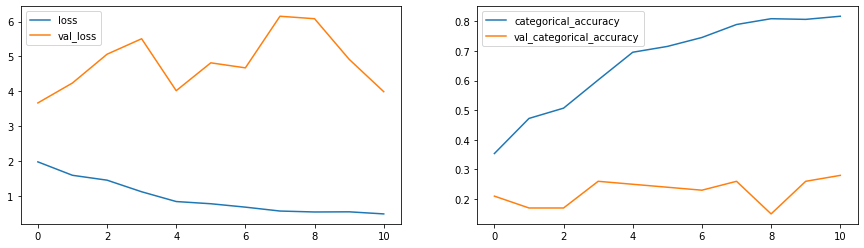

In [12]:
lossAccuracyPlot(history_model2)

##### We can see  val_loss did not improve for last 10 epochs, so early stopping stops the epoch automatically!!  The model is highly overfit as well with no signs or convergence. Changing batch size and number of epochs did not help at all. We will reduce the image size to 120 X 120 and see if the model is converging. Also, we can test with reduced filter size. 
1. Total No. of parameters = 262,506,181
2. Categorical Accuracy = 81.67%
3. Validation Accuracy = 28.00% 

## Model 4 
### Reduce filter size to (2,2,2) and image size to 120 x  120
#### Image Size = 120 X 120, Batch Size = 30, No. of Epochs = 25, Frames to Sample = 16
Image size is reduced and filter size is also reduced. Now we will check the model peformance and then further optimize.

In [13]:
class Conv3DModel_3(GenerateModel):
    
    def setup_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d3=Conv3DModel_3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.setup_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 16, 120, 120, 32)  4128      
                                                                 
 activation_5 (Activation)   (None, 16, 120, 120, 32)  0         
                                                                 
 batch_normalization_7 (Batc  (None, 16, 120, 120, 32)  128      
 hNormalization)                                      

In [15]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 118121781
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.8611 - categorical_accuracy: 0.4072
Epoch 00001: val_loss improved from inf to 4.66492, saving model to model_init_2022-05-1519_05_49.163686/model-00001-1.86112-0.40724-4.66492-0.16000.h5
23/23 [==============================] - 156s 7s/step - loss: 1.8611 - categorical_accuracy: 0.4072 - val_loss: 4.6649 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.2641 - categorical_accuracy: 0.5445
Epoch 00002: val_loss did not improve from 4.66492
23/23 [==============================] - 152s 7s/step - loss: 1.2641 - categorical_accuracy: 0.5445 - val_loss: 14.0455 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.0548 - categorical_accuracy: 0.6214
Epoch 00003: val_loss did not improve from 4.66492
23/23 [==============================] - 152s 7s/step - loss:

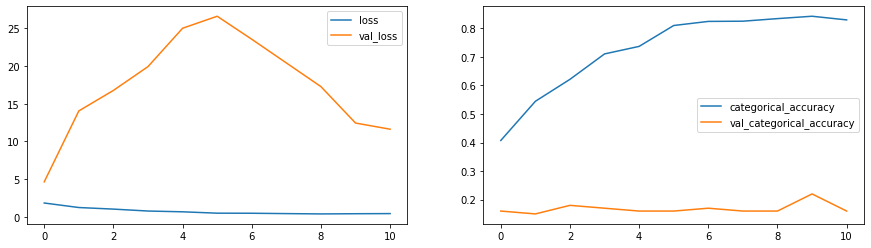

In [16]:
lossAccuracyPlot(history_model3)

##### The model performance still did not improve at all, instead, there is dip in categorical accuracy. This model also stopped early, without executing all the epochs. The model is clearly not converging at all. We will go back to filter size of (3,3,3) and reduce the number of epochs, since all previous models have stopped early. Also, adding dropout at all convolution layers as well.
1. Total No. of parameters = 118,121,781
2. Categorical Accuracy = 82.96%
3. Validation Accuracy = 16.00%

## Model 5 
### Adding dropout at convolution layers
#### Image Size = 120 X 120, Batch Size = 20, No. of Epochs = 15, Frames to Sample = 16
Filter size is set back to (3,3,3) and number of epochs have been reduced to 15. Adding dropout at all the convolution layes as well. We will now check the model performance.

In [11]:
class Conv3DModel_5(GenerateModel):
    
    def setup_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d5=Conv3DModel_5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.setup_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 16, 120, 120, 32)  13856     
                                                                 
 activation_5 (Activation)   (None, 16, 120, 120, 32)  0         
                                                                 
 batch_normalization_7 (Batc  (None, 16, 120, 120, 32)  128      
 hNormalization)                                      

In [13]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 118326981
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.4766 - categorical_accuracy: 0.4864
Epoch 00001: val_loss improved from inf to 3.89838, saving model to model_init_2022-05-1606_19_56.043504/model-00001-1.47659-0.48643-3.89838-0.16000.h5
34/34 [==============================] - 159s 5s/step - loss: 1.4766 - categorical_accuracy: 0.4864 - val_loss: 3.8984 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 0.7353 - categorical_accuracy: 0.7270
Epoch 00002: val_loss did not improve from 3.89838
34/34 [==============================] - 153s 5s/step - loss: 0.7353 - categorical_accuracy: 0.7270 - val_loss: 5.1994 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.5550 - categorical_accuracy: 0.8039
Epoch 00003: val_loss did not improve from 3.89838
34/34 [==============================] - 155s 5s/step - loss: 

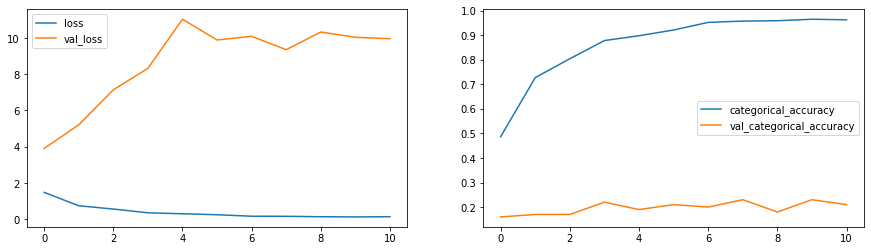

In [15]:
lossAccuracyPlot(history_model5)

#### Overfitting again!! Adding dropouts have also not helped. The model doesn't seem to generalise well. All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance
1. Total No. of parameters = 118,326,981
2. Categorical Accuracy = 96.23%
3. Validation Accuracy = 21.00%

## Model 6 
### Reducing the number of parameters and image size
#### Image Size = 100 X 100, Batch Size = 20, No. of Epochs = 20, Frames to Sample = 16, Dense Neurons = 128, Dropout = 25%
Image Size, Dense Neurons and dropout have been reduced. We will check the model performance and optimize further

In [16]:
class Conv3DModel_6(GenerateModel):
    
    def setup_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d6=Conv3DModel_6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.setup_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_9 (Conv3D)           (None, 16, 100, 100, 32)  4128      
                                                                 
 activation_9 (Activation)   (None, 16, 100, 100, 32)  0         
                                                                 
 batch_normalization_13 (Bat  (None, 16, 100, 100, 32)  128      
 chNormalization)                                     

In [18]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 41066821
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3767 - categorical_accuracy: 0.4842
Epoch 00001: val_loss improved from inf to 5.39991, saving model to model_init_2022-05-1606_51_37.948465/model-00001-1.37666-0.48416-5.39991-0.22000.h5
34/34 [==============================] - 156s 5s/step - loss: 1.3767 - categorical_accuracy: 0.4842 - val_loss: 5.3999 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.8095 - categorical_accuracy: 0.7014
Epoch 00002: val_loss did not improve from 5.39991
34/34 [==============================] - 154s 5s/step - loss: 0.8095 - categorical_accuracy: 0.7014 - val_loss: 10.6766 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.5432 - categorical_accuracy: 0.7994
Epoch 00003: val_loss did not improve from 5.39991
34/34 [==============================] - 155s 5s/step - loss: 

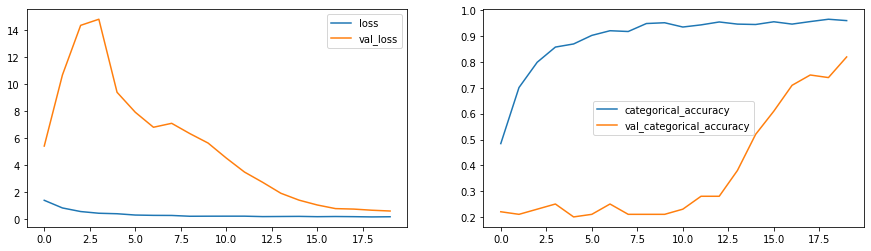

In [19]:
lossAccuracyPlot(history_model6)

###### Reducing the image size and number of parameters have really helped the model to converge. We have got a good validation accuracy of 82%. Though the model is still overfitting. We can reduce the number of parameters again and check if we can better this accuracy
1. Total No. of parameters = 41,066,821
2. Categorical Accuracy = 96.08%
3. Validation Accuracy = 82.00%

## Model 7 
### Reducing the number of parameters again
#### Image Size = 100 X 100, Batch Size = 20, No. of Epochs = 25, Frames to Sample = 16, Dense Neurons = 64, Dropout = 25%
Further reducing the dense layer and dropout. We will check the model performance and optimize further.

In [20]:
class Conv3DModel_7(GenerateModel):
    
    def setup_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d7=Conv3DModel_7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=100,image_width=100)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.setup_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 16, 100, 100, 32)  13856     
                                                                 
 activation_13 (Activation)  (None, 16, 100, 100, 32)  0         
                                                                 
 batch_normalization_19 (Bat  (None, 16, 100, 100, 32)  128      
 chNormalization)                                     

In [22]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 20583301
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6213 - categorical_accuracy: 0.4118
Epoch 00001: val_loss improved from inf to 5.55066, saving model to model_init_2022-05-1607_46_15.773190/model-00001-1.62130-0.41176-5.55066-0.16000.h5
34/34 [==============================] - 157s 5s/step - loss: 1.6213 - categorical_accuracy: 0.4118 - val_loss: 5.5507 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.9479 - categorical_accuracy: 0.6456
Epoch 00002: val_loss did not improve from 5.55066
34/34 [==============================] - 155s 5s/step - loss: 0.9479 - categorical_accuracy: 0.6456 - val_loss: 8.8864 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.7431 - categorical_accuracy: 0.7315
Epoch 00003: val_loss did not improve from 5.55066
34/34 [==============================] - 154s 5s/step - loss: 0

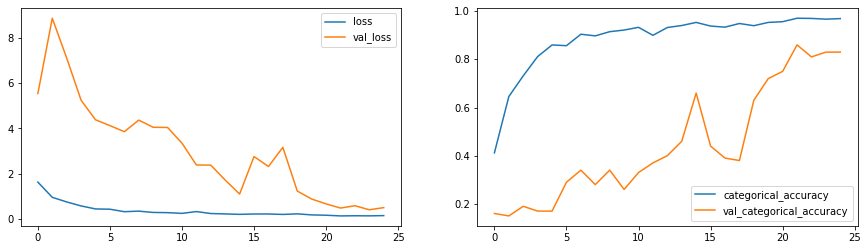

In [23]:
lossAccuracyPlot(history_model7)

###### Reducing the parameters further did not help much compared to previous model. We have similar accuracies. So, now, we will further reduce the image size to 80 X 80 and reduce the number of hidden layers.
1. Total No. of parameters = 20,583,301
2. Categorical Accuracy = 96.91%
3. Validation Accuracy = 83.00%

## Model 8 
### Reducing number of hidden layers and image size = 80 X 80
#### Image Size = 80 X 80, Batch Size = 15, No. of Epochs = 25, Frames to Sample = 16, Dense Neurons = 128, Dropout = 50%
Removing a CNN3D layer and reducing image size to 80 X 80. We have to reduce the batch size to 15.  With batch size 20, disk space of more than 20GB was supported at Jarvis cloud. We were running out of space after epoch 20 itself. So reducing batch size to 15.

In [8]:
class Conv3DModel_8(GenerateModel):
    
    def setup_model(self,filtersize=(3,3,3),dense_neurons=128,dropout=0.5):

        model = Sequential()
        model.add(Conv3D(32, filtersize, padding='same',
                        input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d8=Conv3DModel_8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=80,image_width=80)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=25)
conv_3d8_model=conv_3d8.setup_model(filtersize=(3,3,3),dense_neurons=128,dropout=0.5)
conv_3d8_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 80, 80, 32)    2624      
                                                                 
 activation (Activation)     (None, 16, 80, 80, 32)    0         
                                                                 
 batch_normalization (BatchN  (None, 16, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 80, 80, 64)    55360     
                                                                 
 activation_1 (Activation)   (None, 16, 80, 80, 64)    0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 80, 80, 64)   256       
 hNormalization)                                        

2022-05-16 09:55:50.903990: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-16 09:55:50.904077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [10]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 210013701
Epoch 1/25


2022-05-16 09:55:57.066313: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


45/45 [==============================] - ETA: 0s - loss: 2.2432 - categorical_accuracy: 0.2979
Epoch 00001: val_loss improved from inf to 3.72098, saving model to model_init_2022-05-1609_55_52.912757/model-00001-2.24315-0.29789-3.72098-0.39000.h5
45/45 [==============================] - 191s 4s/step - loss: 2.2432 - categorical_accuracy: 0.2979 - val_loss: 3.7210 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 1.7316 - categorical_accuracy: 0.4027
Epoch 00002: val_loss did not improve from 3.72098
45/45 [==============================] - 155s 3s/step - loss: 1.7316 - categorical_accuracy: 0.4027 - val_loss: 5.3022 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 1.4021 - categorical_accuracy: 0.4910
Epoch 00003: val_loss improved from 3.72098 to 2.19709, saving model to model_init_2022-05-1609_55_52.912757/model-00003-1.40214-0.49095-2.19709-0.29000.h5


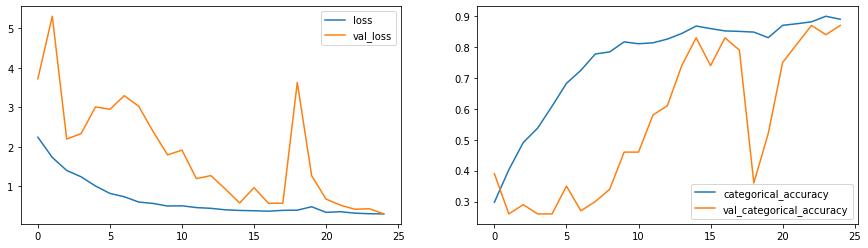

In [11]:
lossAccuracyPlot(history_model8)

##### The model is finally fit with a very good training accuracy of ~89% and validation accuracy of 87%. For now, this seems to be a very good accuracy and we finally have our best CNN3D model. 
1. Total No. of parameters = 210,013,701
2. Categorical Accuracy = 88.99%
3. Validation Accuracy = 87.00%

#### Now, we can try experimenting and building models in CNN2D + RNN.

## 2. CNN  2D + RNN Models

## Model 9 
### CNN2D - LSTM Model
#### Image Size = 120 X 120, Batch Size = 20, No. of Epochs = 20, Frames to Sample = 18, Dense Neurons = 128, Dropout = 25%, LSTM Cells = 128
Initially to start with, we have less number of layers configured for CNN2D and image size is 120X120. We will check the model performance and optimize further.

In [ ]:
class CNN2D_RNN_Model_8(GenerateModel):
    
    def setup_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
rnn_cnn1=CNN2D_RNN_Model_8()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.setup_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 32)  128      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 64)  

In [14]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 14922949
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5166 - categorical_accuracy: 0.3394
Epoch 00001: val_loss improved from inf to 1.91645, saving model to model_init_2022-05-1611_15_52.213165/model-00001-1.51657-0.33937-1.91645-0.16000.h5
34/34 [==============================] - 221s 7s/step - loss: 1.5166 - categorical_accuracy: 0.3394 - val_loss: 1.9164 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3094 - categorical_accuracy: 0.4291
Epoch 00002: val_loss improved from 1.91645 to 1.66895, saving model to model_init_2022-05-1611_15_52.213165/model-00002-1.30941-0.42911-1.66895-0.20000.h5
34/34 [==============================] - 212s 6s/step - loss: 1.3094 - categorical_accuracy: 0.4291 - val_loss: 1.6689 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1421 - categorical_accuracy: 0.5505
Epoch 00003: val_

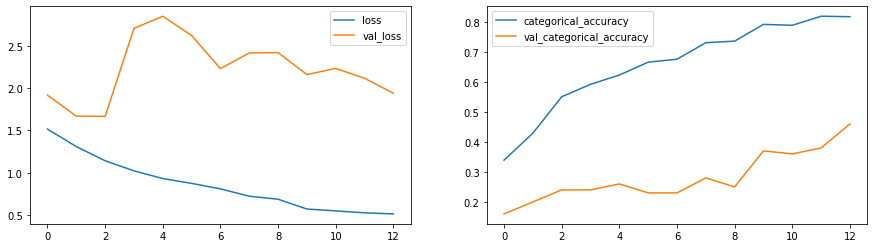

In [15]:
lossAccuracyPlot(history_model8)

##### The model started to converge but could not. It stooped early as there were no convergence for 10 epoch. The model is overfit with a huge gap in training and validation accuracies. We will try and reduce the image size to 100 x 100 and check the performance.
1. Total No. of parameters = 14,922,949
2. Categorical Accuracy = 81.75%
3. Validation Accuracy = 46.00%

## Model 10 
### CNN - LSTM Model - Reducing image size
#### Image Size = 100 X 100, Batch Size = 20, No. of Epochs = 20, Frames to Sample = 18, Dense Neurons = 128, Dropout = 25%, LSTM Cells = 128
Reducing the image size to 100 x 100 and checking its performance.

In [11]:
rnn_cnn2=CNN2D_RNN_Model_8()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=100,image_width=100)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.setup_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

2022-05-16 12:25:32.065755: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-16 12:25:32.065825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 100, 100, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 100, 100, 32)  128      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 50, 50, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 50, 50, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 50, 50, 64)   2

In [16]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model10=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 9614533
Epoch 1/20


2022-05-16 12:27:54.359396: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.5109 - categorical_accuracy: 0.3567
Epoch 00001: val_loss improved from inf to 1.93081, saving model to model_init_2022-05-1612_27_45.403017/model-00001-1.51086-0.35671-1.93081-0.16000.h5
34/34 [==============================] - 182s 5s/step - loss: 1.5109 - categorical_accuracy: 0.3567 - val_loss: 1.9308 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2335 - categorical_accuracy: 0.5045
Epoch 00002: val_loss did not improve from 1.93081
34/34 [==============================] - 177s 5s/step - loss: 1.2335 - categorical_accuracy: 0.5045 - val_loss: 1.9591 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0925 - categorical_accuracy: 0.5611
Epoch 00003: val_loss improved from 1.93081 to 1.89298, saving model to model_init_2022-05-1612_27_45.403017/model-00003-1.09255-0.56109-1.89298-0.19000.h5


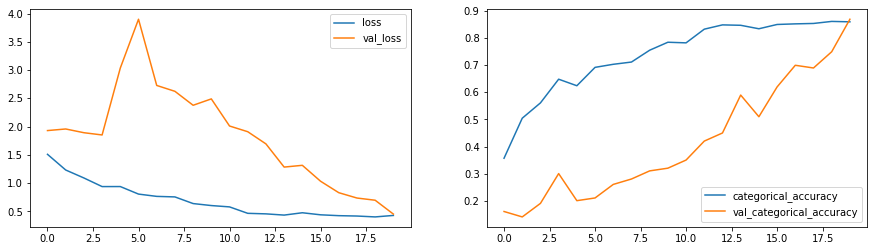

In [17]:
lossAccuracyPlot(history_model10)

##### We have got a good training accuracy of 86% and validation accuracy of 87%. The model is fit and seems to be best model in CNN2D + RNN combination. We will reduce the image size further to check if we can achieve better accuracy.
1. Total No. of parameters = 9,614,533
2. Categorical Accuracy = 86.05%
3. Validation Accuracy = 87.00%

## Model 11
### CNN2D - LSTM Model - Further reducing image size
#### Image Size = 80 X 80, Batch Size = 20, No. of Epochs = 20, Frames to Sample = 18, Dense Neurons = 128, Dropout = 25%, LSTM Cells = 128
Reducing the image size further to check if it improves the accuracy further.

In [18]:
rnn_cnn3=CNN2D_RNN_Model_8()
rnn_cnn3.initialize_path(project_folder)
rnn_cnn3.initialize_image_properties(image_height=80,image_width=80)
rnn_cnn3.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn3_model=rnn_cnn3.setup_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn3_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 18, 80, 80, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 18, 80, 80, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 18, 40, 40, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 18, 40, 40, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 18, 40, 40, 64)  

In [19]:
print("Total Params:", rnn_cnn3_model.count_params())
history_model11=rnn_cnn3.train_model(rnn_cnn3_model,augment_data=True)

Total Params: 6730949
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5163 - categorical_accuracy: 0.3544
Epoch 00001: val_loss improved from inf to 1.75182, saving model to model_init_2022-05-1613_28_28.231696/model-00001-1.51634-0.35445-1.75182-0.24000.h5
34/34 [==============================] - 174s 5s/step - loss: 1.5163 - categorical_accuracy: 0.3544 - val_loss: 1.7518 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3018 - categorical_accuracy: 0.4465
Epoch 00002: val_loss improved from 1.75182 to 1.75177, saving model to model_init_2022-05-1613_28_28.231696/model-00002-1.30183-0.44646-1.75177-0.17000.h5
34/34 [==============================] - 171s 5s/step - loss: 1.3018 - categorical_accuracy: 0.4465 - val_loss: 1.7518 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0831 - categorical_accuracy: 0.5732
Epoch 00003: val_l

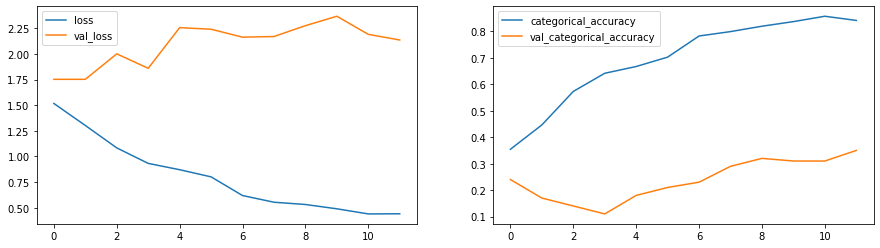

In [20]:
lossAccuracyPlot(history_model11)

##### The model is overfit, failing to converge further. It stopped early as there were no convergence for last 10 epochs. So, clearly, image size of 80x80 has not improved, instead, drastically reduced the performance.
1. Total No. of parameters = 6,730,949
2. Categorical Accuracy = 84.16%
3. Validation Accuracy = 35.00%

#### We will try now building model with GRU and check its performance.

## Model 12 
### CNN2D LSTM with GRU
#### Image Size = 100 X 100, Batch Size = 20, No. of Epochs = 20, Frames to Sample = 18, Dense Neurons = 128, Dropout = 25%, LSTM Cells = 128
Taking the best CNN LSTM model (model with image size 100 x 100) and adding GRU layer to it. Checking its performance

In [21]:
class CNN2D_RNN_Model_9(GenerateModel):
    
    def setup_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
rnn_cnn2=CNN2D_RNN_Model_9()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=100,image_width=100)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.setup_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 18, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 18, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 18, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 18, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 18, 50, 50, 32)  

In [23]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 1934949
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4390 - categorical_accuracy: 0.3922
Epoch 00001: val_loss improved from inf to 1.63081, saving model to model_init_2022-05-1614_08_22.548168/model-00001-1.43899-0.39216-1.63081-0.26000.h5
34/34 [==============================] - 179s 5s/step - loss: 1.4390 - categorical_accuracy: 0.3922 - val_loss: 1.6308 - val_categorical_accuracy: 0.2600 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9336 - categorical_accuracy: 0.6448
Epoch 00002: val_loss did not improve from 1.63081
34/34 [==============================] - 183s 6s/step - loss: 0.9336 - categorical_accuracy: 0.6448 - val_loss: 1.8105 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7046 - categorical_accuracy: 0.7489
Epoch 00003: val_loss did not improve from 1.63081
34/34 [==============================] - 181s 5s/step - loss: 0.

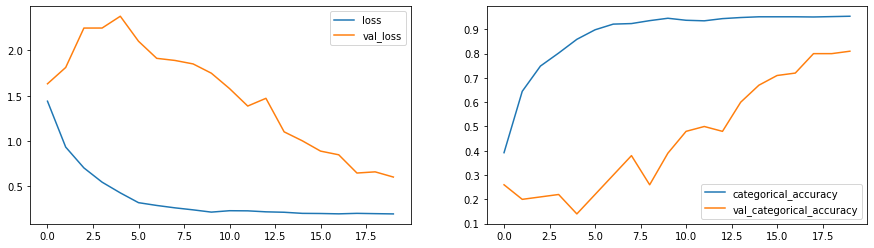

In [24]:
lossAccuracyPlot(history_model15)

#### Adding GRU layer improved the training accuracy but did not improve the validation accuracy, hence overfitting the model. 
1. Total No. of parameters = 1,934,949
2. Categorical Accuracy = 95.40%
3. Validation Accuracy = 81.00%


## 3. Transfer Learning Models

## Model 13 - Transfer Learning 
### Using Mobilenet
#### Image Size = 100 X 100, Batch Size = 5, No. of Epochs = 20, Frames to Sample = 16, Dense Neurons = 128, Dropout = 25%, LSTM Cells = 128
__(Optional)__

In [25]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. 

from keras.applications import mobilenet

In [26]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class TL_Model_10(GenerateModel):
    
    def setup_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 0s 0us/step


In [27]:
rnn_cnn_tl=TL_Model_10()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=100,image_width=100)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.setup_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)              

In [28]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2838 - categorical_accuracy: 0.4698
Epoch 00001: val_loss improved from inf to 0.82912, saving model to model_init_2022-05-1615_08_33.410438/model-00001-1.28385-0.46983-0.82912-0.71000.h5
133/133 [==============================] - 163s 1s/step - loss: 1.2838 - categorical_accuracy: 0.4698 - val_loss: 0.8291 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7524 - categorical_accuracy: 0.7217
Epoch 00002: val_loss improved from 0.82912 to 0.60569, saving model to model_init_2022-05-1615_08_33.410438/model-00002-0.75241-0.72172-0.60569-0.76000.h5
133/133 [==============================] - 164s 1s/step - loss: 0.7524 - categorical_accuracy: 0.7217 - val_loss: 0.6057 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5463 - categorical_accuracy: 0.8167
Epoch 00

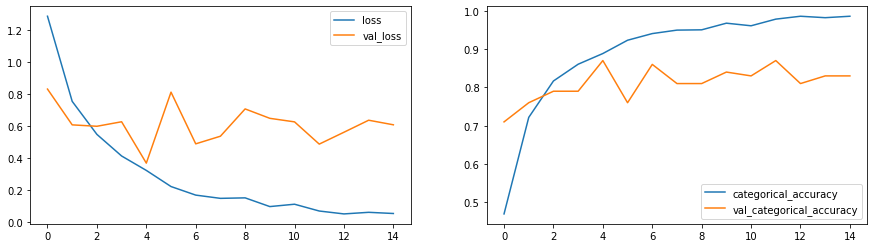

In [29]:
lossAccuracyPlot(history_model16)

##### We are not training the mobilenet weights and we see validation accuracy is  poor and model if overfit. Let's train them as well and observe if there is performance improvement
1. Total No. of parameters = 3,840,453
2. Categorical Accuracy = 98.57%
3. Validation Accuracy = 83.00%

## Model 14 - Transfer Learning with GRU
### Training all weights
#### Image Size = 100 X 100, Batch Size = 5, No. of Epochs = 20, Frames to Sample = 16, Dense Neurons = 128, Dropout = 25%, LSTM Cells = 128
__(Optional)__

In [8]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class TL_Model_11(GenerateModel):
    
    def setup_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

2022-05-16 19:25:35.973198: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-16 19:25:35.973261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [9]:
rnn_cnn_tl2=TL_Model_11()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=100,image_width=100)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.setup_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

In [10]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20


2022-05-16 19:26:06.793098: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


133/133 [==============================] - ETA: 0s - loss: 1.0386 - categorical_accuracy: 0.6011
Epoch 00001: val_loss improved from inf to 0.48965, saving model to model_init_2022-05-1619_26_01.255097/model-00001-1.03856-0.60106-0.48965-0.81000.h5
133/133 [==============================] - 158s 1s/step - loss: 1.0386 - categorical_accuracy: 0.6011 - val_loss: 0.4897 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.5462 - categorical_accuracy: 0.8137
Epoch 00002: val_loss improved from 0.48965 to 0.34084, saving model to model_init_2022-05-1619_26_01.255097/model-00002-0.54623-0.81373-0.34084-0.91000.h5
133/133 [==============================] - 152s 1s/step - loss: 0.5462 - categorical_accuracy: 0.8137 - val_loss: 0.3408 - val_categorical_accuracy: 0.9100 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.3808 - categorical_accuracy: 0.8763
Epoch 00003: val_loss improved from 0.340

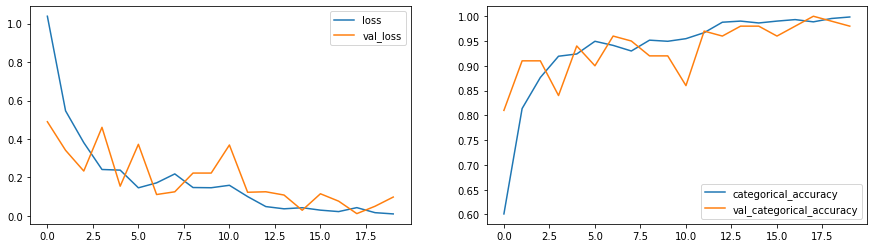

In [11]:
lossAccuracyPlot(history_model17)

### Awesome results! 99.85% Training accuracy and 98% validation accuracy :)
##### Training the weights have improved the model accuracy and produced a best fit model.
1. Total No. of parameters = 3,693,253
2. Categorical Accuracy = 99.85%
3. Validation Accuracy = 98.00%

# Consolidated Models Summary

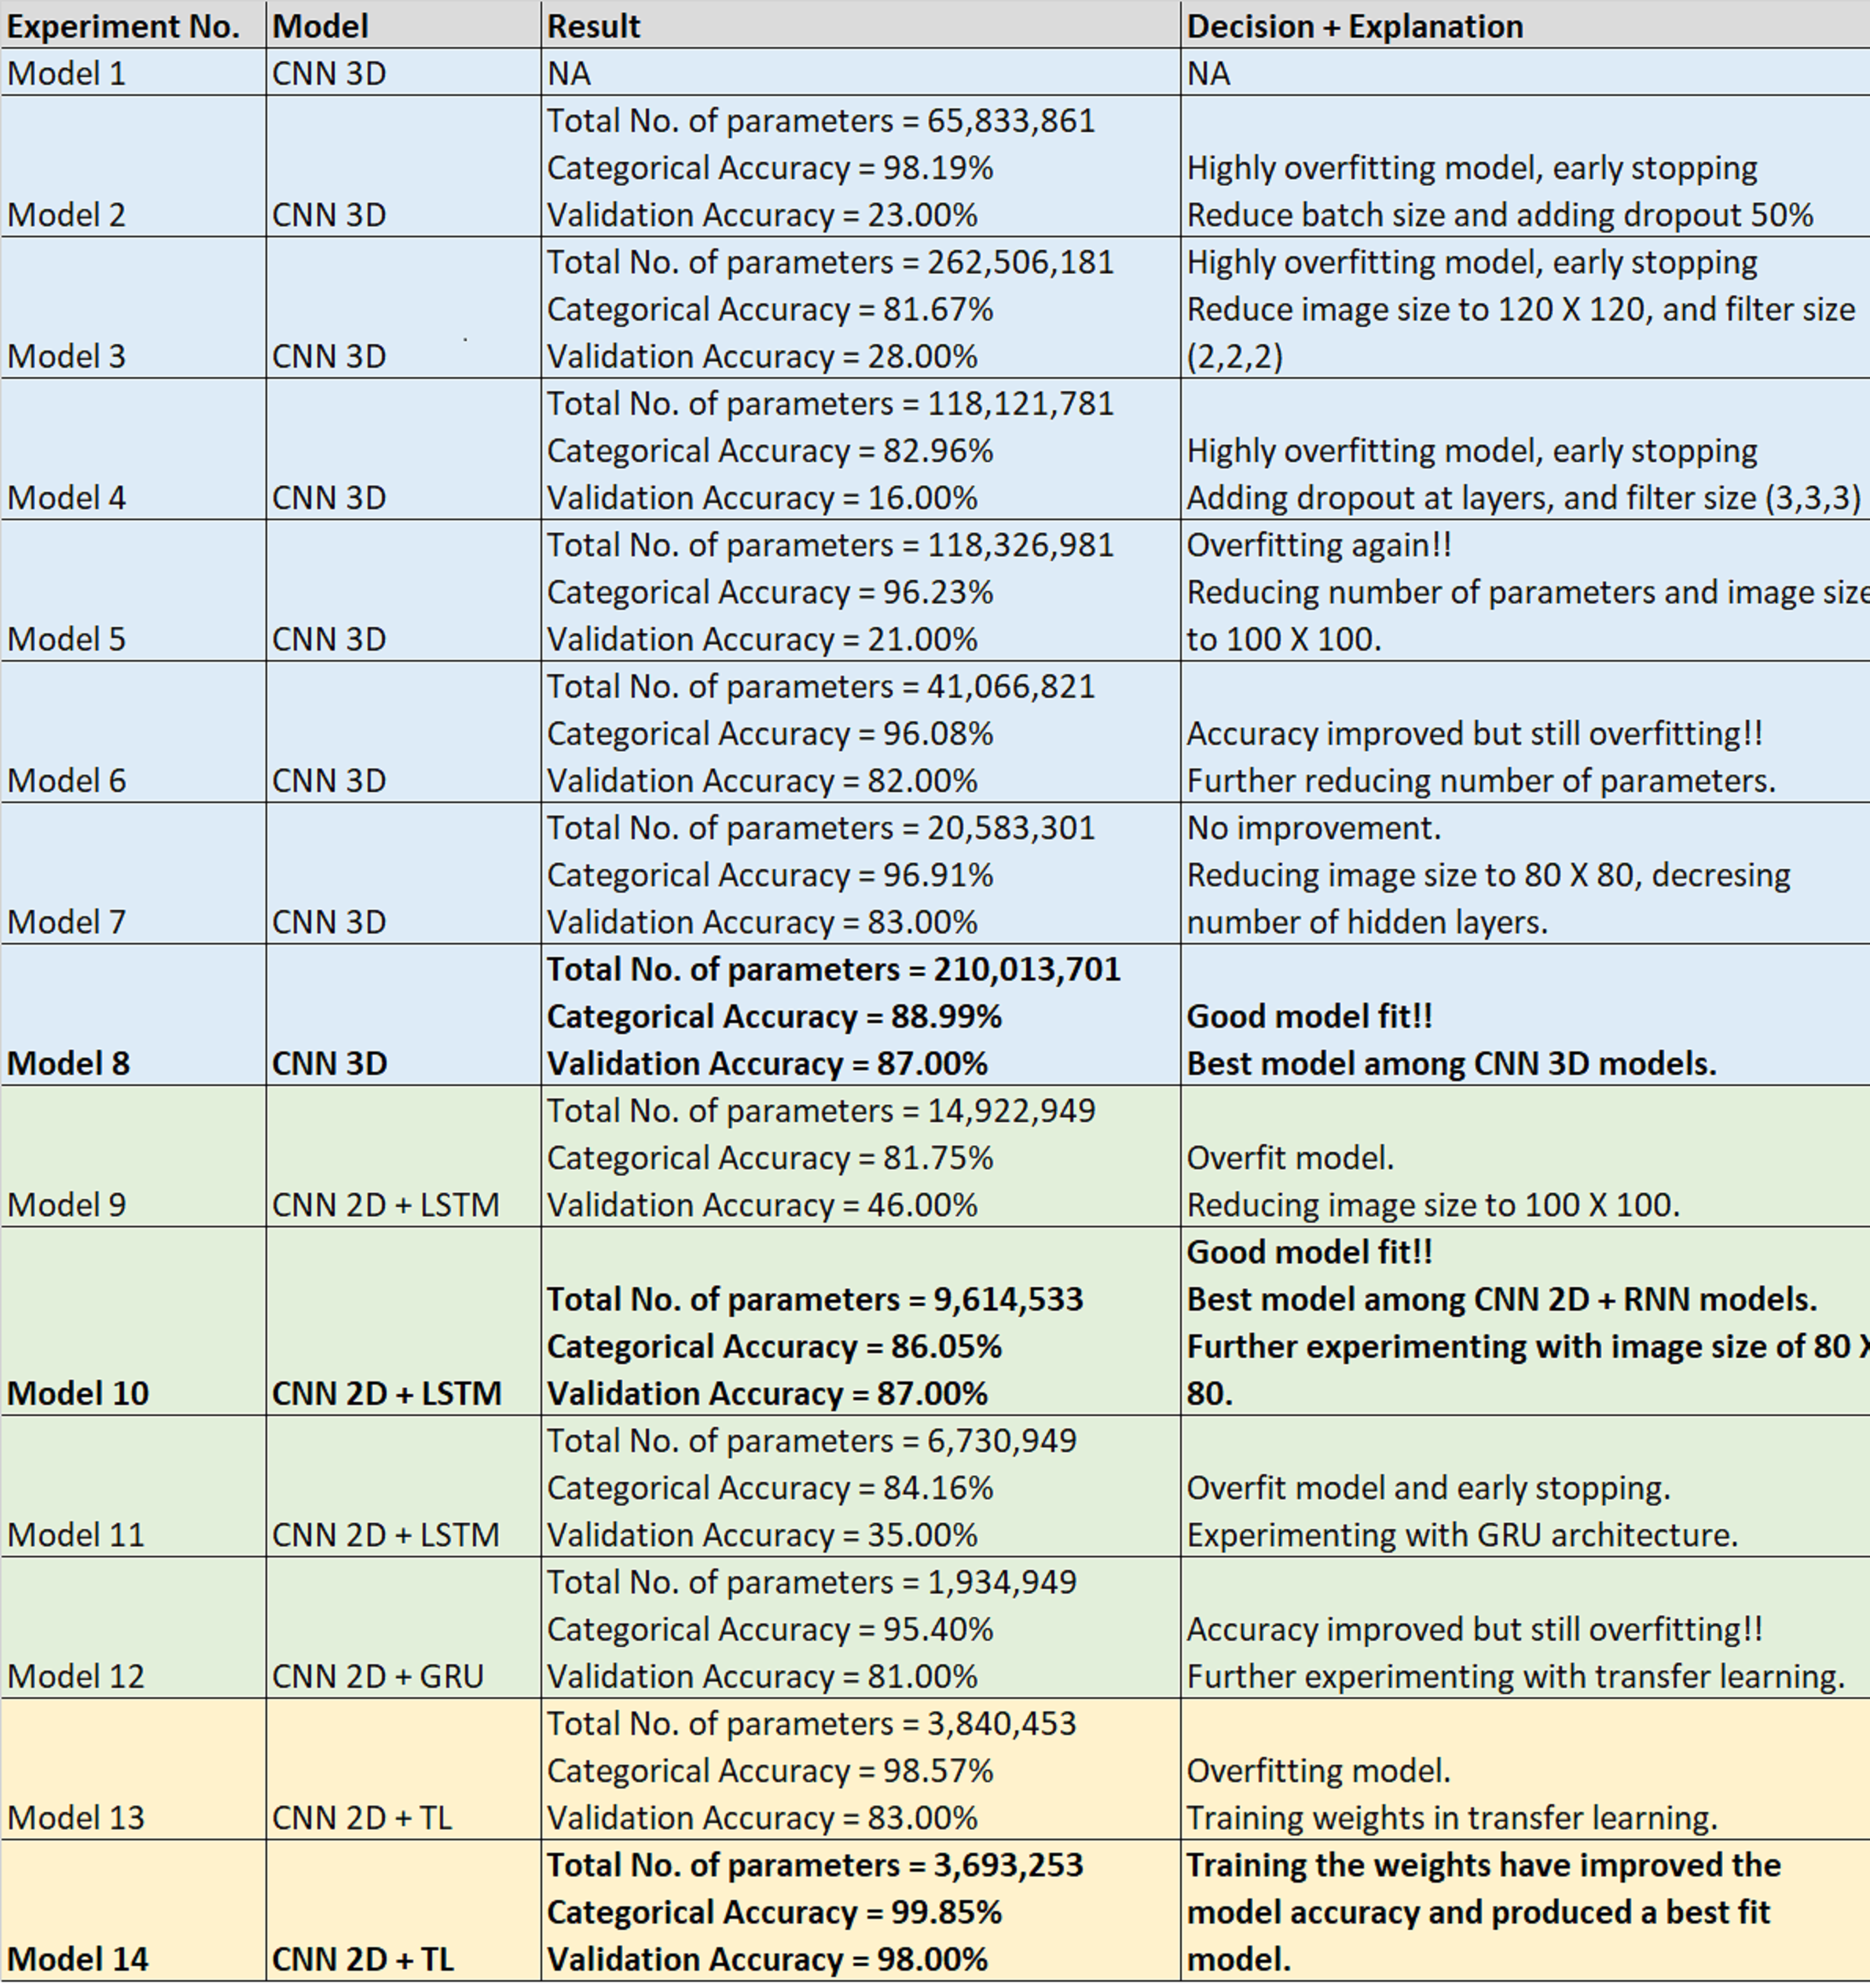

# Conclusion

### After doing all the experiments, we found that the Model 8 (CNN 3D) and Model 10 (Cnn2D + LSTM) have best results. 

### Lets compare these 2 models to get a better understanding, which will help us decide the best model between these two models.

#### Model 8 (CNN 3D):
1. Total No. of parameters = 210,013,701
2. Categorical Accuracy = 88.99%
3. Validation Accuracy = 87.00%


#### Model 10 (CNN2D + LSTM):
1. Total No. of parameters = 9,614,533
2. Categorical Accuracy = 86.05%
3. Validation Accuracy = 87.00%


Based on the above details about the model, Model 10 (CNN2D + LSTM), is the BEST model, because:
1. Both models have similar accuracy, but model 10 was able to produce same result with very less number of parameters (only 9,614,533) as compared to Model 8 which uses much more parameters (210,013,701).
2. Model 10 uses LSTM, which is better suited to handle sequential data.
3. Since Model 10 has very less parameters, processing time required in Model 10 is much less compared to Model 8. i.e. Model 10 is much faster.
4. The image size used is Model 10 is 100X100 which is greater than the image size of Model 8, Hence not much information loss compared to Model 8.


__The best weights of CNN-LSTM: model_init_2022-05-1612_27_45.403017/model-00020-0.42984-0.86048-0.45405-0.87000.h5 (110 MB). We should consider this weight for model testing__
